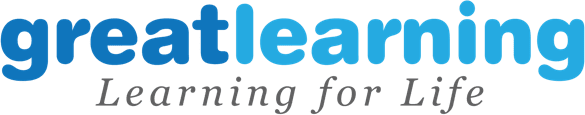






# **Mask vs No Mask Detection Challenge** 

1. **Problem Description:**

Due to the COVID19 pandemic, wearing face masks has become a norm. A lot of Surveillance systems are integrating computer vision in order to monitor whether citizens are wearing masks or not. In this challenge you will build a model that is able to distinguish between images with people wearing mask vs people not wearing a mask

2. **Objective:**

Classify an image containing a **Face as “with_mask” or “without_mask”** depending on whether the person is wearing a mask or not. 

3. **Dataset:**

You have been provided with a Dataset comprising images of people wearing masks and not wearing masks. You have also been provided with 3 csv files named train.csv, test.csv and sample_submission.csv

train.csv consists of the labels for the images in the train folder
test.csv consists of the names of the test files on which you need to make predictions
sample_submission.csv shows the format in which you need to make a submission

4. **Expected Steps:**

*   Clean and pre-process the data.
*   Use any algorithm to create a model that classifies an image into two categories: with_mask and without_mask. ( Please use label 1 for with_mask and label 0 for without_mask ) 
*   Make predictions on the test dataset and create a csv file similar to sample_submission.csv and submit your solution on the platform

In [1]:
import tensorflow
tensorflow.__version__

'2.4.0'

In [2]:
from google.colab import drive
import os

from zipfile import ZipFile
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import cv2
import h5py

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/My Drive/AIML/GreatLearning/CV Hackathon/')

In [5]:
project_path = '/content/drive/My Drive/AIML/GreatLearning/CV Hackathon/'

In [6]:
train_dataset_path = project_path + 'train.zip'

In [9]:
with ZipFile(train_dataset_path, 'r') as z:
  z.extractall()
print("Training Dataset extraction done!")

Training Dataset extraction done!


In [7]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [8]:
# metadata = load_metadata('images')
training_metadata = load_metadata('train')

In [9]:
print(training_metadata[0].base)
print(training_metadata[0].file)
print(training_metadata[0].name)
training_metadata[0]

train
516.jpg
No Mask_Train


train/No Mask_Train/516.jpg

In [10]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [11]:
person1 = load_image(str(training_metadata[0]))

In [12]:
%matplotlib inline
person1 = cv2.cvtColor(person1,cv2.COLOR_BGR2RGB)

In [13]:
person1.shape

(91, 59, 3)

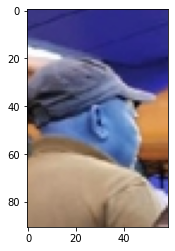

In [14]:
plt.imshow(person1)

In [15]:
train_map_data  = pd.read_csv('train.csv') 
train_map_data.head()

,file_id,label
0,190,1
1,190,1
2,191,1
3,192,1
4,193,1


In [16]:
train_map_data.shape

(591, 2)

In [17]:
file_path = training_metadata[0]
file_name = str(file_path.file)
res = [int(i) for i in file_name.split(".") if i.isdigit()]
print("Picture number::", res[0])

Picture number:: 516


In [18]:
dupes = train_map_data.duplicated()
sum(dupes)

1

In [19]:
train_map_data =train_map_data.drop_duplicates()

In [20]:
sum(train_map_data.duplicated())

0

In [21]:
train_map_data.isnull().sum()

file_id    0
label      0
dtype: int64

In [22]:
train_map_data[train_map_data["file_id"] == [int(i) for i in file_name.split(".") if i.isdigit()][0]]["label"]

517    0
Name: label, dtype: int64

In [23]:
def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

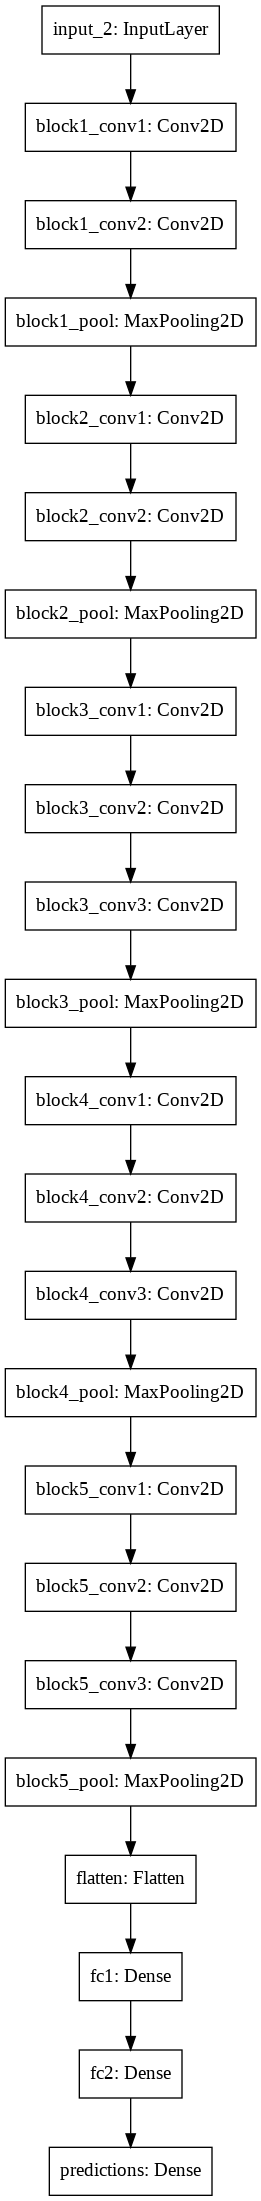

In [25]:

from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model

#model = vgg_face()
model = VGG16()
plot_model(model, to_file='vgg.png')

#model.load_weights(project_path + 'vgg_face_weights.h5')

In [26]:
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.output)

In [27]:
vgg_face_descriptor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
#optimizer = Adam(lr = 0.0006)
optimizer = Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#optimizer='rmsprop'
vgg_face_descriptor.compile(loss="crossentropy",optimizer=optimizer)

In [29]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = training_metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(1000,)


In [30]:
embeddings = np.zeros((training_metadata.shape[0], 1000))

for i, m in enumerate(training_metadata):
  img_path = m.image_path()
  img = load_image(img_path)

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)

  img = cv2.resize(img, dsize = (224,224))
  #print(img.shape)

  # Obtain embedding vector for an image
  # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

  embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

In [31]:
embeddings[8]

array([1.99481612e-04, 2.26321677e-03, 5.41676127e-04, 8.38533684e-04,
       1.91362225e-03, 1.10487489e-03, 5.58348559e-03, 2.04782540e-04,
       1.47044411e-04, 1.19920558e-04, 7.98421563e-04, 3.30863812e-04,
       6.49908150e-04, 1.59765140e-03, 2.71667144e-04, 2.17401612e-04,
       7.38267496e-04, 2.78502761e-04, 3.89585592e-04, 1.28464843e-03,
       9.08201502e-04, 8.60011904e-04, 6.21780229e-04, 2.86532450e-04,
       1.35532406e-04, 9.88453467e-05, 8.41265835e-04, 4.25546139e-04,
       1.11502282e-04, 5.63570252e-03, 1.96710869e-04, 3.64685402e-04,
       1.76875343e-04, 1.51903636e-03, 1.76434871e-03, 3.53451032e-04,
       1.19679840e-03, 2.28600940e-04, 1.63312419e-03, 3.31938383e-04,
       7.30729138e-04, 2.84058158e-04, 4.67835896e-04, 3.39981227e-04,
       4.06541774e-04, 1.96674396e-03, 6.67890185e-04, 8.32439866e-04,
       8.56185623e-04, 5.35971776e-04, 9.96593735e-04, 2.22997449e-04,
       1.33408397e-03, 1.79702102e-03, 6.35823701e-04, 4.18875163e-04,
      

In [32]:
np.save('embeddings_train.npy', embeddings)

In [33]:
train_emb = np.load('embeddings_train.npy')

In [34]:
train_emb[8]

array([1.99481612e-04, 2.26321677e-03, 5.41676127e-04, 8.38533684e-04,
       1.91362225e-03, 1.10487489e-03, 5.58348559e-03, 2.04782540e-04,
       1.47044411e-04, 1.19920558e-04, 7.98421563e-04, 3.30863812e-04,
       6.49908150e-04, 1.59765140e-03, 2.71667144e-04, 2.17401612e-04,
       7.38267496e-04, 2.78502761e-04, 3.89585592e-04, 1.28464843e-03,
       9.08201502e-04, 8.60011904e-04, 6.21780229e-04, 2.86532450e-04,
       1.35532406e-04, 9.88453467e-05, 8.41265835e-04, 4.25546139e-04,
       1.11502282e-04, 5.63570252e-03, 1.96710869e-04, 3.64685402e-04,
       1.76875343e-04, 1.51903636e-03, 1.76434871e-03, 3.53451032e-04,
       1.19679840e-03, 2.28600940e-04, 1.63312419e-03, 3.31938383e-04,
       7.30729138e-04, 2.84058158e-04, 4.67835896e-04, 3.39981227e-04,
       4.06541774e-04, 1.96674396e-03, 6.67890185e-04, 8.32439866e-04,
       8.56185623e-04, 5.35971776e-04, 9.96593735e-04, 2.22997449e-04,
       1.33408397e-03, 1.79702102e-03, 6.35823701e-04, 4.18875163e-04,
      

In [35]:
def img_distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [36]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {img_distance(train_emb[idx1], train_emb[idx2]):.6f}')
    plt.subplot(121)
    plt.imshow(load_image(training_metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(training_metadata[idx2].image_path()));    

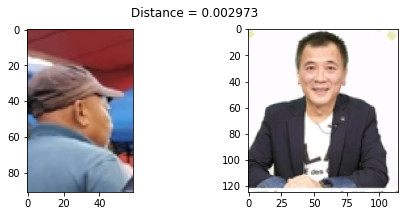

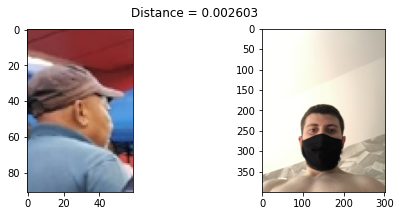

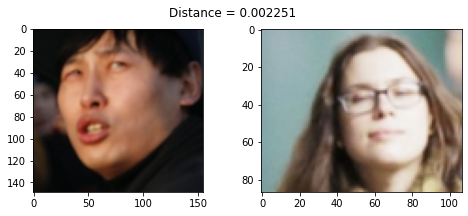

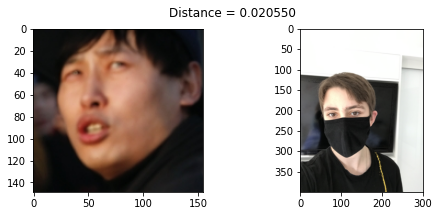

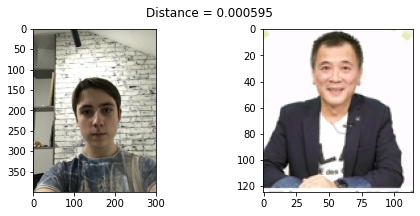

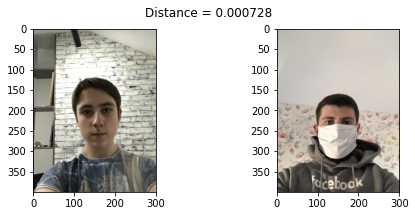

In [37]:
show_pair(0, 37)
show_pair(0, 180)
show_pair(30, 31)
show_pair(30, 200)
show_pair(70, 37)
show_pair(70, 115)

In [38]:
X = train_emb[np.arange(training_metadata.shape[0])]

In [39]:
target_list = []

for m in training_metadata:
  file_name = str(m.file)
  res = [int(i) for i in file_name.split(".") if i.isdigit()]
  label = train_map_data[train_map_data["file_id"] == res[0]].label
  target_list.append(label)

y = np.array(target_list)  

In [40]:
y.shape

(590, 1)

In [41]:
le = LabelEncoder() 
y_labeled = le.fit_transform(y)
y_labeled.shape

(590,)

In [42]:
scaler = StandardScaler()
XScaled = scaler.fit_transform(X)
XScaled.shape

(590, 1000)

In [73]:
covMatrix = np.cov(XScaled,rowvar=False)
print(covMatrix)

[[ 1.00169779  0.48788966 -0.11152625 ... -0.0707625   0.32859172
  -0.72738405]
 [ 0.48788966  1.00169779 -0.02927602 ... -0.21045752  0.35719163
  -0.46126478]
 [-0.11152625 -0.02927602  1.00169779 ... -0.08570239 -0.24027325
   0.10217003]
 ...
 [-0.0707625  -0.21045752 -0.08570239 ...  1.00169779 -0.08486021
   0.13286446]
 [ 0.32859172  0.35719163 -0.24027325 ... -0.08486021  1.00169779
  -0.25295379]
 [-0.72738405 -0.46126478  0.10217003 ...  0.13286446 -0.25295379
   1.00169779]]


In [74]:
pca = PCA(n_components=100)
pca.fit(XScaled)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [75]:
print(pca.explained_variance_)

[822.67398302 262.52133656 135.09208302 107.98161403  91.5987299
  84.44549543  64.15573776  58.4856614   43.25759901  38.77896995
  36.436816    32.95145554  27.58162257  23.72184764  22.14963175
  20.29653282  18.14790859  16.06886457  15.17338928  14.60955741
  14.16965968  13.68699935  12.6027717   11.45627076  10.91471718
  10.51330857   9.77829242   9.57258558   9.09295074   8.19615108
   7.70194466   7.59221299   7.36767997   7.13042864   6.96380573
   6.73347584   6.33943619   6.14762513   6.09509206   5.84939666
   5.67672193   5.54751679   5.46976629   5.23329273   5.16309926
   5.11546039   4.95561964   4.88433592   4.73073125   4.59952919
   4.50137642   4.40126354   4.32978191   4.19648649   4.05343943
   3.95298923   3.87084419   3.79877402   3.67115676   3.63634863
   3.60533589   3.54280228   3.46179691   3.41653358   3.35609265
   3.32975785   3.30698839   3.24271435   3.17282154   3.15448064
   3.13197857   3.08610585   3.03096613   2.99184141   2.95219382
   2.921818

In [76]:
print(pca.components_)

[[ 3.08594864e-02  1.86311565e-02  2.63666174e-05 ... -4.46858878e-03
   1.08015658e-02 -2.60996329e-02]
 [-1.55378300e-03 -1.76183529e-02 -3.83097076e-03 ...  3.98758953e-02
  -1.20495917e-02  3.59920998e-03]
 [ 1.06335772e-02  2.40401352e-02 -2.17032637e-03 ...  1.81705300e-02
   1.25491370e-02 -2.00072680e-02]
 ...
 [-6.85000856e-03  5.89419705e-02  1.60206039e-03 ...  2.76201044e-02
   3.11644942e-03  3.12078022e-02]
 [-5.15142074e-03 -2.03561260e-02  1.38716926e-03 ...  2.89290990e-02
   5.47320312e-02  1.06522735e-02]
 [ 2.84516777e-03 -2.42698465e-03 -6.66175057e-03 ...  2.75860273e-03
   3.93272328e-02 -1.36493476e-03]]


In [77]:
print(pca.explained_variance_ratio_)

[0.3132264  0.09995285 0.05143521 0.04111312 0.03487547 0.03215193
 0.02442677 0.02226794 0.01646998 0.01476478 0.01387302 0.012546
 0.01050148 0.0090319  0.00843329 0.00772774 0.00690967 0.00611809
 0.00577714 0.00556247 0.00539498 0.00521121 0.0047984  0.00436188
 0.00415569 0.00400286 0.003723   0.00364468 0.00346207 0.00312062
 0.00293245 0.00289067 0.00280518 0.00271485 0.00265141 0.00256372
 0.00241369 0.00234066 0.00232066 0.00222711 0.00216137 0.00211217
 0.00208257 0.00199253 0.00196581 0.00194767 0.00188681 0.00185967
 0.00180119 0.00175123 0.00171386 0.00167575 0.00164853 0.00159778
 0.00154331 0.00150507 0.00147379 0.00144635 0.00139776 0.00138451
 0.0013727  0.00134889 0.00131805 0.00130082 0.0012778  0.00126778
 0.00125911 0.00123464 0.00120803 0.00120104 0.00119248 0.00117501
 0.00115402 0.00113912 0.00112402 0.00111246 0.00109942 0.00108558
 0.00107686 0.00106178 0.00104207 0.00102813 0.00099896 0.00099556
 0.00098784 0.00098322 0.00097468 0.00096424 0.00094234 0.000926

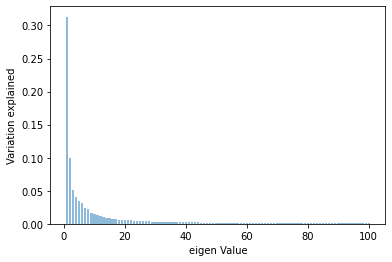

In [78]:
plt.bar(list(range(1,101)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

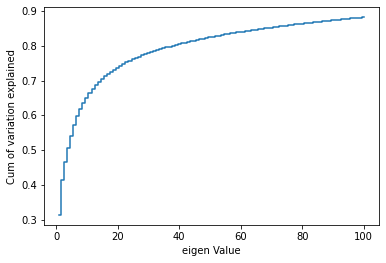

In [79]:
plt.step(list(range(1,101)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [81]:
pca = PCA(n_components=46)
pca.fit(XScaled)
print(pca.components_)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(XScaled)

[[ 3.08594864e-02  1.86311565e-02  2.63666174e-05 ... -4.46858878e-03
   1.08015658e-02 -2.60996329e-02]
 [-1.55378301e-03 -1.76183529e-02 -3.83097077e-03 ...  3.98758953e-02
  -1.20495917e-02  3.59920997e-03]
 [ 1.06335771e-02  2.40401353e-02 -2.17032642e-03 ...  1.81705301e-02
   1.25491372e-02 -2.00072681e-02]
 ...
 [ 8.64284675e-04  1.59359960e-02 -1.52687579e-02 ... -1.04889965e-02
  -2.10262019e-02  6.29466388e-03]
 [-1.54152239e-02  2.42525832e-02 -7.63891592e-04 ...  1.78510397e-02
  -1.04657294e-02  1.87137100e-03]
 [-1.22707581e-02  4.82930610e-03 -3.28615956e-02 ... -2.59267662e-02
  -4.79377783e-03 -2.82603222e-03]]
[0.3132264  0.09995285 0.05143521 0.04111312 0.03487547 0.03215193
 0.02442677 0.02226794 0.01646998 0.01476478 0.01387302 0.012546
 0.01050148 0.0090319  0.00843329 0.00772774 0.00690967 0.00611809
 0.00577714 0.00556247 0.00539498 0.00521121 0.0047984  0.00436188
 0.00415569 0.00400286 0.00372301 0.00364469 0.00346207 0.00312062
 0.00293238 0.00289058 0.002805

In [82]:
X_pca.shape

(590, 46)

In [202]:
train_idx = np.arange(training_metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
val_idx = np.arange(training_metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = X_pca[train_idx]
# another half as test examples of 10 identities
X_val = X_pca[val_idx]

#train labels
y_train = y_labeled[train_idx]
#test labels
y_val = y_labeled[val_idx]

In [43]:
X_train, X_val, y_train, y_val = train_test_split(XScaled, y_labeled, test_size=0.3, random_state=1)
print("Size of the training dataframe is ",len(X_train))
print("Size of the test dataframe is ",len(X_val))
print("{0:0.2f}% data is in training set".format((len(X_train)/len(XScaled)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_val)/len(XScaled)) * 100))

Size of the training dataframe is  413
Size of the test dataframe is  177
70.00% data is in training set
30.00% data is in test set


In [44]:
svcModels=[]
svcModels.append(('SVC_1',SVC(),X_train, X_val, y_train, y_val))
svcModels.append(('SVC_0_rbf_gamma',SVC(gamma=0.025),X_train, X_val, y_train, y_val))
svcModels.append(('SVC_0_rbf__gamma_C3',SVC(gamma=0.005, C=3),X_train, X_val, y_train, y_val))
svcModels.append(('SVC_0_linear',SVC(kernel='linear'),X_train, X_val, y_train, y_val))
svcModels.append(('SVC_0_linear_gamma',SVC(kernel='linear',gamma=0.025),X_train, X_val, y_train, y_val))
svcModels.append(('SVC_0_linear_C3',SVC(kernel='linear',C=3),X_train, X_val, y_train, y_val))
svcModels.append(('SVC_0_linear_C5',SVC(kernel='linear',C=5),X_train, X_val, y_train, y_val))
svcModels.append(('SVC_0_linear_C9',SVC(kernel='linear',C=9),X_train, X_val, y_train, y_val))

In [45]:
def fit_n_print(model, Xtrain, Xtest, ytrain, ytest):  # take the model, and data as inputs
        
    model.fit(X_train, y_train)   # fir the model with the train data

    train_score = round(model.score(Xtrain, ytrain), 5)
    val_scrore = round(model.score(Xtest, ytest), 5)   # compute accuracy score for test set
    
    return train_score, val_scrore

In [46]:
result1 = pd.DataFrame({'Model':[],'Training Accuracy(%)':[],'Validation Accuracy(%)':[]})
for name,model,X_train, X_val, y_train, y_val in svcModels:
    train_accuracy, val_accuracy = fit_n_print(model, X_train, X_val, y_train, y_val)
    result1 = result1.append(pd.Series({'Model':name, 'Training Accuracy(%)':train_accuracy * 100, 'Validation Accuracy(%)':val_accuracy * 100}), ignore_index=True)
print(result1)

                 Model  Training Accuracy(%)  Validation Accuracy(%)
0                SVC_1                86.683                  79.661
1      SVC_0_rbf_gamma               100.000                  79.096
2  SVC_0_rbf__gamma_C3               100.000                  80.226
3         SVC_0_linear               100.000                  81.921
4   SVC_0_linear_gamma               100.000                  81.921
5      SVC_0_linear_C3               100.000                  81.921
6      SVC_0_linear_C5               100.000                  81.921
7      SVC_0_linear_C9               100.000                  81.921


# **Test Data Processing**

In [47]:
test_dataset_path = project_path + 'test.zip'

In [ ]:
with ZipFile(test_dataset_path, 'r') as z:
  z.extractall()
print("Test Dataset extraction done!")

In [48]:
class IdentityTestMetadata():
    def __init__(self, base, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 
    
def load_test_metadata(path):
    metadata = []
    for i in os.listdir(path):
      ext = os.path.splitext(i)[1]
      if ext == '.jpg' or ext == '.jpeg':
        metadata.append(IdentityTestMetadata(path, i))
    return np.array(metadata)

In [49]:
test_metadata = load_test_metadata("test data")

In [50]:
test_metadata[0].file

'44.jpg'

In [53]:
test_embeddings = np.zeros((test_metadata.shape[0], 1000))
for i, m in enumerate(test_metadata):
  img_path = m.image_path()
  if img_path != "test data/30.jpg" :
    img = load_image(img_path) 
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    test_embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

In [54]:
test_embeddings[8]

array([2.04598036e-04, 3.10037518e-03, 4.85216442e-04, 6.77899865e-04,
       2.63033854e-03, 9.27608286e-04, 4.95219370e-03, 2.56829953e-04,
       1.70224434e-04, 1.34858259e-04, 4.95017041e-04, 1.85737284e-04,
       5.06420038e-04, 1.13677827e-03, 2.09206686e-04, 1.83295924e-04,
       4.99760208e-04, 2.47832941e-04, 3.42916261e-04, 8.97439895e-04,
       7.12532899e-04, 8.34578823e-04, 5.56632935e-04, 2.87091621e-04,
       8.02779978e-05, 7.34211862e-05, 7.59385934e-04, 4.15015907e-04,
       6.86195563e-05, 9.77386907e-03, 2.03924414e-04, 3.18637409e-04,
       2.10314320e-04, 2.88003916e-03, 2.65423697e-03, 3.40320315e-04,
       1.49056560e-03, 1.89438273e-04, 1.67749345e-03, 3.57415003e-04,
       7.40767224e-04, 3.01111868e-04, 4.84353281e-04, 4.20832279e-04,
       3.37794831e-04, 1.51403574e-03, 5.96714846e-04, 7.17206334e-04,
       8.48606403e-04, 6.51351642e-04, 1.43783668e-03, 2.22608156e-04,
       7.11311877e-04, 8.06974131e-04, 5.06329467e-04, 2.44563125e-04,
      

In [55]:
np.save('embeddings_test.npy', test_embeddings)
test_emb = np.load('embeddings_test.npy')
test_emb[8]

array([2.04598036e-04, 3.10037518e-03, 4.85216442e-04, 6.77899865e-04,
       2.63033854e-03, 9.27608286e-04, 4.95219370e-03, 2.56829953e-04,
       1.70224434e-04, 1.34858259e-04, 4.95017041e-04, 1.85737284e-04,
       5.06420038e-04, 1.13677827e-03, 2.09206686e-04, 1.83295924e-04,
       4.99760208e-04, 2.47832941e-04, 3.42916261e-04, 8.97439895e-04,
       7.12532899e-04, 8.34578823e-04, 5.56632935e-04, 2.87091621e-04,
       8.02779978e-05, 7.34211862e-05, 7.59385934e-04, 4.15015907e-04,
       6.86195563e-05, 9.77386907e-03, 2.03924414e-04, 3.18637409e-04,
       2.10314320e-04, 2.88003916e-03, 2.65423697e-03, 3.40320315e-04,
       1.49056560e-03, 1.89438273e-04, 1.67749345e-03, 3.57415003e-04,
       7.40767224e-04, 3.01111868e-04, 4.84353281e-04, 4.20832279e-04,
       3.37794831e-04, 1.51403574e-03, 5.96714846e-04, 7.17206334e-04,
       8.48606403e-04, 6.51351642e-04, 1.43783668e-03, 2.22608156e-04,
       7.11311877e-04, 8.06974131e-04, 5.06329467e-04, 2.44563125e-04,
      

In [56]:
X_test = test_emb[np.arange(test_metadata.shape[0])]

In [57]:
scaler = StandardScaler()
XScaled_test = scaler.fit_transform(X_test)
XScaled_test.shape

(46, 1000)

In [100]:
test_pca = PCA(n_components=46)
test_pca.fit(XScaled_test)
print(test_pca.components_)
print(test_pca.explained_variance_ratio_)

[[ 3.14610140e-02  2.02696565e-02 -5.62092983e-03 ... -2.80345632e-03
   1.01110242e-02 -2.66966279e-02]
 [ 5.72990713e-03  2.54752268e-02 -1.40752216e-02 ... -4.07897290e-02
   2.01788859e-02 -1.49243255e-02]
 [ 2.13253780e-03  2.45342191e-02  4.49994258e-03 ... -9.50592012e-03
   2.62292217e-03 -3.47435855e-03]
 ...
 [ 7.58201601e-03 -4.31218997e-02  2.10303799e-02 ...  1.57401209e-02
  -3.09614710e-02  1.47976696e-02]
 [-7.51730215e-03 -4.10472646e-04  2.45889306e-02 ...  7.28442587e-03
   1.41728558e-02 -4.11965351e-03]
 [-7.48853723e-01 -1.72286340e-01 -4.17078997e-02 ...  2.22148988e-03
   1.64206516e-02 -1.47552528e-03]]
[3.40894864e-01 1.23965775e-01 8.06724048e-02 5.17082009e-02
 3.94290753e-02 3.80570094e-02 3.29806728e-02 2.66837913e-02
 1.89621267e-02 1.72399813e-02 1.64939883e-02 1.37272458e-02
 1.31347081e-02 1.19533109e-02 1.06531053e-02 9.79514717e-03
 9.68467291e-03 8.93977201e-03 8.86749587e-03 8.08247719e-03
 7.90767978e-03 7.31363598e-03 7.19094743e-03 6.57952372e-0

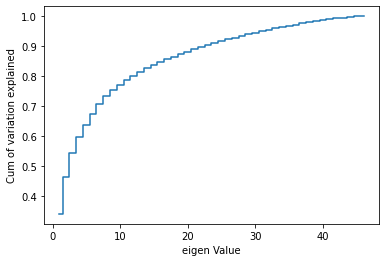

In [101]:
plt.step(list(range(1,47)),np.cumsum(test_pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [102]:
test_pca = PCA(n_components=46)
test_pca.fit(XScaled_test)
print(test_pca.components_)
print(test_pca.explained_variance_ratio_)
XTest_pca = test_pca.transform(XScaled_test)

[[ 3.14610140e-02  2.02696565e-02 -5.62092983e-03 ... -2.80345632e-03
   1.01110242e-02 -2.66966279e-02]
 [ 5.72990713e-03  2.54752268e-02 -1.40752216e-02 ... -4.07897290e-02
   2.01788859e-02 -1.49243255e-02]
 [ 2.13253780e-03  2.45342191e-02  4.49994258e-03 ... -9.50592012e-03
   2.62292217e-03 -3.47435855e-03]
 ...
 [ 7.58201601e-03 -4.31218997e-02  2.10303799e-02 ...  1.57401209e-02
  -3.09614710e-02  1.47976696e-02]
 [-7.51730215e-03 -4.10472646e-04  2.45889306e-02 ...  7.28442587e-03
   1.41728558e-02 -4.11965351e-03]
 [-7.48853723e-01 -1.72286340e-01 -4.17078997e-02 ...  2.22148988e-03
   1.64206516e-02 -1.47552528e-03]]
[3.40894864e-01 1.23965775e-01 8.06724048e-02 5.17082009e-02
 3.94290753e-02 3.80570094e-02 3.29806728e-02 2.66837913e-02
 1.89621267e-02 1.72399813e-02 1.64939883e-02 1.37272458e-02
 1.31347081e-02 1.19533109e-02 1.06531053e-02 9.79514717e-03
 9.68467291e-03 8.93977201e-03 8.86749587e-03 8.08247719e-03
 7.90767978e-03 7.31363598e-03 7.19094743e-03 6.57952372e-0

### Model 1

In [71]:
pred_model = SVC()
pred_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [72]:
test_result = pd.DataFrame({'file_id':[],'label':[]})
test_prediction = pred_model.predict(XScaled_test)
for i in range(46):
  file_path = test_metadata[i]
  file_name = str(file_path.file)
  res = [int(i) for i in file_name.split(".") if i.isdigit()]
  test_result = test_result.append(pd.Series({'file_id':str(res[0]), 'label':str(test_prediction[i])}), ignore_index=True)
print(test_result)

   file_id label
0       44     1
1       33     1
2       20     1
3       31     1
4       42     1
5        9     1
6       40     1
7        2     1
8       12     1
9       16     1
10      36     1
11      23     1
12      25     1
13       0     1
14      18     1
15       5     1
16      10     1
17       1     1
18      26     1
19       4     1
20      21     1
21       3     1
22      13     1
23       8     1
24       7     0
25      17     1
26      32     1
27      41     1
28      35     1
29      24     1
30      37     1
31       6     1
32      28     1
33      45     1
34      43     1
35      15     1
36      19     0
37      29     1
38      34     1
39      11     1
40      38     1
41      22     1
42      14     1
43      39     1
44      27     1
45      30     1


In [129]:
test_result.to_csv('test.csv', index=False)

### Model 2

In [61]:
pred_model_2 = SVC(kernel='linear',C=9)
pred_model_2.fit(X_train, y_train)

SVC(C=9, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [62]:
test_result_2 = pd.DataFrame({'file_id':[],'label':[]})
test_prediction = pred_model_2.predict(XScaled_test)
for i in range(46):
  file_path = test_metadata[i]
  file_name = str(file_path.file)
  res = [int(i) for i in file_name.split(".") if i.isdigit()]
  test_result_2 = test_result_2.append(pd.Series({'file_id':str(res[0]), 'label':str(test_prediction[i])}), ignore_index=True)
print(test_result_2)

   file_id label
0       44     1
1       33     1
2       20     1
3       31     0
4       42     1
5        9     1
6       40     1
7        2     1
8       12     1
9       16     1
10      36     0
11      23     1
12      25     1
13       0     1
14      18     1
15       5     1
16      10     1
17       1     1
18      26     1
19       4     1
20      21     1
21       3     1
22      13     1
23       8     1
24       7     0
25      17     1
26      32     0
27      41     1
28      35     0
29      24     1
30      37     0
31       6     1
32      28     1
33      45     1
34      43     1
35      15     1
36      19     1
37      29     1
38      34     1
39      11     1
40      38     1
41      22     1
42      14     1
43      39     1
44      27     1
45      30     1


In [288]:
test_result_2.to_csv('test_scaled_softmax.csv', index=False)

In [154]:
from sklearn.model_selection import StratifiedKFold

In [290]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(XScaled,y_labeled):
    print('{} of KFold {}'.format(i,kf.n_splits))
    x_tr,x_vl = X_pca[train_index],X_pca[test_index]
    y_tr,y_vl = y_labeled[train_index],y_labeled[test_index]
    
    #model
    clf = SVC(kernel='linear')  
    clf.fit(x_tr , y_tr)
    score = round(clf.score(x_vl, y_vl), 3) 
    print('Score:',score)
    cv_score.append(score)    
    i+=1

1 of KFold 10
Score: 0.831
2 of KFold 10
Score: 0.881
3 of KFold 10
Score: 0.847
4 of KFold 10
Score: 0.864
5 of KFold 10
Score: 0.831
6 of KFold 10
Score: 0.847
7 of KFold 10
Score: 0.847
8 of KFold 10
Score: 0.847
9 of KFold 10
Score: 0.847
10 of KFold 10
Score: 0.864


In [300]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(gamma=0.0005, C=3)
scores = cross_val_score(clf, XScaled,y_labeled, cv=10)
print("Best cross validation score of the model:: {0}%".format(scores[4]*100))

Best cross validation score of the model:: 86.4406779661017%


In [302]:
pred_model_3 = SVC(gamma=0.0005, C=3)
pred_model_3.fit(XScaled, y_labeled)

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [305]:
test_result_2 = pd.DataFrame({'file_id':[],'label':[]})
#test_prediction = pred_model_3.predict(XScaled_test)
for i in range(46):
  file_path = test_metadata[i]
  test_prediction = pred_model_3.predict(XScaled_test[i])
  file_name = str(file_path.file)
  res = [int(i) for i in file_name.split(".") if i.isdigit()]
  test_result_2 = test_result_2.append(pd.Series({'file_id':str(res[0]), 'label':str(test_prediction)}), ignore_index=True)
print(test_result_2)

   file_id label
0       35     1
1        6     1
2       37     0
3       24     1
4       43     1
5       15     1
6       45     1
7       28     1
8       29     1
9       19     1
10      34     0
11      11     1
12      38     1
13      22     1
14      14     1
15      39     1
16      27     0
17      30     1
18      44     1
19      33     1
20      20     1
21      31     0
22      42     1
23       9     1
24      40     1
25       2     1
26      12     1
27      16     1
28      36     0
29      23     1
30      25     1
31       0     1
32      18     1
33       5     1
34      10     1
35       1     1
36      26     1
37       4     1
38      21     1
39       3     1
40      13     1
41       8     1
42       7     1
43      17     1
44      32     1
45      41     1


In [74]:
from keras.models import load_model

In [143]:
model_1 = load_model('facenet_keras.h5')  

In [76]:
model_1.load_weights('facenet_keras_weights.h5')

In [183]:
optimizer = Adam(lr = 0.00006)
model_1.compile(loss="binary_crossentropy",optimizer=optimizer)

In [184]:
embeddings = np.zeros((training_metadata.shape[0], 128))

for i, m in enumerate(training_metadata):
  img_path = m.image_path()
  img = load_image(img_path)

  # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
  img = (img / 255.).astype(np.float32)

  img = cv2.resize(img, dsize = (160,160))
  #print(img.shape)

  # Obtain embedding vector for an image
  # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

  embeddings[i] = model_1.predict(np.expand_dims(img, axis=0))[0]

In [185]:
embeddings[0]

array([ 0.26945257, -0.30281603, -0.22635552, -0.49108079,  0.17723805,
       -0.09506904,  0.01678741, -0.08152553,  0.38435727, -0.40688589,
        0.48415834, -0.39236182, -0.12410598, -0.76273096, -0.03289944,
       -0.06013105,  0.69766986, -0.46792692,  0.23921372, -0.41027853,
       -0.19360881,  0.08105171, -0.89884019,  0.25951701,  0.2220646 ,
        0.1705045 ,  0.54037392,  0.34448868, -0.13678442,  0.10809412,
        0.23597078,  0.36112776, -0.21370542, -0.26769191,  0.05729882,
       -0.18904746,  0.00635452,  0.49963385,  0.61399674,  0.26838022,
        0.06840937, -0.0280604 ,  0.17969362, -0.47947082, -0.57251865,
       -0.28669685, -0.14300404, -0.32805941,  0.20402601,  0.04044516,
        0.29025316,  0.36947352,  0.51501596, -0.74819231,  0.10371549,
        0.78593516, -0.08347949, -0.48397774, -0.06629913, -0.53942424,
       -0.33321911, -0.17412293,  0.07618041,  0.74210095,  0.14191261,
        0.33144879,  0.0628726 , -0.18706194, -0.24330589, -0.28

In [186]:
X = embeddings[np.arange(training_metadata.shape[0])] 

In [187]:
from sklearn.preprocessing import Normalizer

in_encoder = Normalizer(norm='l2')
X = in_encoder.transform(X)

In [190]:
X_train, X_val, y_train, y_val = train_test_split(X, y_labeled, test_size=0.15, random_state=1)
print("Size of the training dataframe is ",len(X_train))
print("Size of the test dataframe is ",len(X_val))
print("{0:0.2f}% data is in training set".format((len(X_train)/len(X)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_val)/len(X)) * 100))

Size of the training dataframe is  501
Size of the test dataframe is  89
84.92% data is in training set
15.08% data is in test set


In [191]:
result1 = pd.DataFrame({'Model':[],'Training Accuracy(%)':[],'Validation Accuracy(%)':[]})
for name,model,X_train, X_val, y_train, y_val in svcModels:
    train_accuracy, val_accuracy = fit_n_print(model, X_train, X_val, y_train, y_val)
    result1 = result1.append(pd.Series({'Model':name, 'Training Accuracy(%)':train_accuracy * 100, 'Validation Accuracy(%)':val_accuracy * 100}), ignore_index=True)
print(result1)

                 Model  Training Accuracy(%)  Validation Accuracy(%)
0                SVC_1                86.683                  79.661
1      SVC_0_rbf_gamma               100.000                  79.096
2  SVC_0_rbf__gamma_C3               100.000                  80.226
3         SVC_0_linear               100.000                  81.921
4   SVC_0_linear_gamma               100.000                  81.921
5      SVC_0_linear_C3               100.000                  81.921
6      SVC_0_linear_C5               100.000                  81.921
7      SVC_0_linear_C9               100.000                  81.921


In [150]:
svcModel = SVC()
svcModel.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [151]:
score_train = svcModel.score(X_train, y_train)
score_val = svcModel.score(X_val, y_val)
print(score_train)
print(score_val)

0.8208232445520581
0.7909604519774012


In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

d_tree_model = DecisionTreeClassifier()

In [153]:
parameters={'min_samples_split' : range(10,15,20),'max_depth': range(1,20,2)}
modelChk =GridSearchCV(estimator=d_tree_model,
             param_grid=parameters)

modelChk.fit(X_train, y_train)

print("Best Hyper Parameters:\n", modelChk.best_params_)

Best Hyper Parameters:
 {'max_depth': 1, 'min_samples_split': 10}


In [154]:
modelChk.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [155]:
best_mod = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [156]:
best_mod.fit(X_train, y_train)
best_mod.score(X_train, y_train)

0.8208232445520581

In [157]:
best_mod.fit(X_val, y_val) 
best_mod.score(X_val, y_val)

0.8022598870056498

In [164]:
test_embeddings = np.zeros((test_metadata.shape[0], 128))
for i, m in enumerate(test_metadata):
  img_path = m.image_path()
  if img_path != "test data/47.jpg" :
    img = load_image(img_path) 
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (160,160))
    test_embeddings[i] = model_1.predict(np.expand_dims(img, axis=0))[0]

In [165]:
X_test = test_embeddings[np.arange(test_metadata.shape[0])]

In [166]:
X_test = in_encoder.transform(X_test)

In [167]:
facenet_result = pd.DataFrame({'file_id':[],'label':[]})
test_prediction = best_mod.predict(X_test)
for i in range(46):
  file_path = test_metadata[i]
  file_name = str(file_path.file)
  res = [int(i) for i in file_name.split(".") if i.isdigit()]
  facenet_result = facenet_result.append(pd.Series({'file_id':str(res[0]), 'label':str(test_prediction[i])}), ignore_index=True)
print(facenet_result)

   file_id label
0       44     0
1       33     0
2       20     1
3       31     1
4       42     1
5        9     1
6       40     0
7        2     0
8       12     1
9       16     0
10      36     0
11      23     1
12      25     1
13       0     1
14      18     1
15       5     1
16      10     1
17       1     1
18      26     1
19       4     1
20      21     1
21       3     1
22      13     1
23       8     1
24       7     0
25      17     1
26      32     1
27      41     1
28      35     0
29      24     1
30      37     0
31       6     1
32      28     1
33      45     1
34      43     0
35      15     0
36      19     1
37      29     0
38      34     0
39      11     1
40      38     0
41      22     1
42      14     1
43      39     1
44      27     0
45      30     0


In [168]:
facenet_result.to_csv('test_facenet_2.csv', index=False)

In [113]:
from sklearn.ensemble import RandomForestClassifier

In [169]:
rForest_model = RandomForestClassifier()

In [177]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 3, 4],
               'min_samples_split': [2, 3, 5, 10],
               'n_estimators': [130, 150, 180, 230]}

rf_random = RandomizedSearchCV(estimator = rForest_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

print("Best Hyper Parameters:\n", rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


Best Hyper Parameters:
 {'n_estimators': 130, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


In [178]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=130,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [179]:
best_rf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=130,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [180]:
best_rf.fit(X_train, y_train)
best_rf.score(X_train, y_train)

1.0

In [181]:
best_rf.score(X_val, y_val)

0.8135593220338984

In [182]:
facenet_result_rf = pd.DataFrame({'file_id':[],'label':[]})
test_prediction = best_rf.predict(X_test)
for i in range(46):
  file_path = test_metadata[i]
  file_name = str(file_path.file)
  res = [int(i) for i in file_name.split(".") if i.isdigit()]
  facenet_result_rf = facenet_result_rf.append(pd.Series({'file_id':str(res[0]), 'label':str(test_prediction[i])}), ignore_index=True)
print(facenet_result_rf)
facenet_result_rf.to_csv('facenet_result_rf.csv', index=False)

   file_id label
0       44     1
1       33     1
2       20     1
3       31     1
4       42     1
5        9     0
6       40     1
7        2     1
8       12     1
9       16     1
10      36     1
11      23     1
12      25     1
13       0     1
14      18     1
15       5     1
16      10     1
17       1     1
18      26     1
19       4     1
20      21     1
21       3     1
22      13     1
23       8     1
24       7     1
25      17     1
26      32     1
27      41     1
28      35     1
29      24     1
30      37     0
31       6     1
32      28     1
33      45     1
34      43     1
35      15     1
36      19     1
37      29     1
38      34     1
39      11     1
40      38     1
41      22     1
42      14     1
43      39     1
44      27     1
45      30     1


[1]


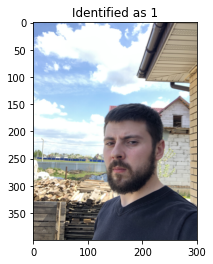

In [142]:
example_idx = 0
X_test[example_idx]

example_image = load_image(test_metadata[example_idx].image_path())
example_prediction = best_rf.predict([X_test[example_idx]])
example_identity = le.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');
print(example_prediction)

In [192]:
train_idx = np.arange(training_metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
val_idx = np.arange(training_metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = X[train_idx]
# another half as test examples of 10 identities
X_val = X[val_idx]

#train labels
y_train = y_labeled[train_idx]
#test labels
y_val = y_labeled[val_idx]

In [193]:
best_rf.fit(X_train, y_train)
best_rf.score(X_train, y_train)

0.9961832061068703

In [194]:
best_rf.score(X_val, y_val)

0.8181818181818182

In [199]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

In [202]:
def Stacking(model,n_fold,train,test,y):
    folds= StratifiedKFold(n_splits=n_fold,random_state=1)
    train_pred=np.empty((0,1),float)
    for train_indices,val_indices in folds.split(train,y):
        X_train_s,X_val=X[train_indices],X[val_indices]
        y_train_s,y_val=y[train_indices],y[val_indices]
        model.fit(X=X_train_s,y=y_train_s)
        train_pred=np.append(train_pred,model.predict(X_val))
    test_pred=model.predict(test)
    return test_pred.reshape(-1,1),train_pred

In [203]:
model1 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

test_pred1 ,train_pred1=Stacking(model=model1,n_fold=10, train=X,test=X_test,y=y_labeled)
train_pred1=pd.DataFrame(train_pred1)
test_pred1=pd.DataFrame(test_pred1)

In [209]:
model2 = SVC()
test_pred2 ,train_pred2=Stacking(model=model2,n_fold=10, train=X,test=X_test,y=y_labeled)
train_pred2=pd.DataFrame(train_pred2)
test_pred2=pd.DataFrame(test_pred2)

In [215]:
model3 = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=130,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

test_pred3 ,train_pred3=Stacking(model=model3,n_fold=10, train=X,test=X_test,y=y_labeled)
train_pred3=pd.DataFrame(train_pred3)
test_pred3=pd.DataFrame(test_pred3)

In [216]:
df_train = pd.concat([train_pred1, train_pred2, train_pred3], axis=1)
df_test = pd.concat([test_pred1, test_pred2, test_pred3], axis=1)

In [217]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(df_train,y_labeled)
model.score(df_train,y_labeled)

0.811864406779661